#  Hierarchical Clustering and MNIST

In this notebook we will do use multiclass logistic regression to classify MNIST. If you are using your own installation of Jupyter you will need the mnist package which can be installed through anaconda using

conda install -c conda-forge mnist

I must point out that no efforts have been made to optimise this code for either efficiency or elegance, and some of you will no doubt be able to find ways in which it could be improved.

**CAUTION** these notebooks are great, but you must be careful when running the cells out of order, especially if you are using mutable variables

In [5]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
from numpy.linalg import inv, det

First, some manipulations. We need to linearise the training data so that we can treat each image as a vector.

In [6]:
# Get the training and test data
train_set = mnist.train_images()
train_labels = mnist.train_labels()
test_set = mnist.test_images()
test_labels = mnist.test_labels()
print(test_set.shape)
print(train_set.shape)

# Reshape the arrays
test_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in test_set]))
train_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in train_set]))
print(test_set.shape)
print(train_set.shape)

(10000, 28, 28)
(60000, 28, 28)
(10000, 784)
(60000, 784)


## Preprocessing of the data

One problem with the MNIST data is that there are, as we have previously seen, many non-varying pixels around the edge of the images. In LR we do not need to compute the covariance matrix but they risk confounding the classifier so we will remove them.


In [7]:
# Get the sum of each variable into a single vector
S = np.sum(train_set,axis=0).squeeze()

# Define an index of the non-varying and varying pixels
nonvary = S==0
vary = np.array(S!=0).squeeze()

# Choose only the varying pixels in the data
train_set = train_set[:,vary]
test_set = test_set[:,vary]

We're going to roll our own implementation of the algorithm because it's instructive to see how this method is implemented recursively.

In [8]:
from scipy.spatial.distance import euclidean
from collections import Iterable
def agghier(x, dfun=euclidean, linktype='average'):
    '''
    Args:
    x: numpy.ndarray: data points, one point per row
    dfun: function for distance calculation
    linktype: 'single', 'average', 'complete'

    Returns:
    ClusterCentroids: numpy.ndarray: N rows, one centroid per row
    Labels: numpy.ndarray: label of closest centroid for each datapoint.
    '''

    # Flatten lists of lists, needed to enable linkage to be computed
    def flatten(x):
        if isinstance(x, Iterable):
            return [a for i in x[0:2] for a in flatten(i)]
        else:
            return [x]

    # The linker, compute distances between clusters by flattening them and using the appropriate metric
    def linker(c1,c2,x,metric,linkage):
        # First flatten the clusters
        c1flat = flatten(c1)
        c2flat = flatten(c2)
        # Get the data corresponding to the two clusters
        x1 = x[c1flat,:]
        x2 = x[c2flat,:]
        # Compute all pairwise distances
        d = np.zeros([len(x1),len(x2)])
        for i1,p1 in enumerate(x1):
            for i2,p2 in enumerate(x2):
                d[i1,i2] = metric(p1,p2)
        return linkage(d)

    # Recursive hierarchical clustering
    def docluster(x, clusters, distances, linker):
        # The base case is the final merge of the two sides of the tree
        if len(clusters) == 2:
            clusters.append(linker(clusters[0],clusters[1],x))
            return clusters
        # Otherwise we evaluate the current position and proceed recursively
        else:
            # Find the shortest distance in the current set of clusters
            d = np.zeros([len(clusters), len(clusters)])
            for i,c1 in enumerate(clusters):
                for j,c2 in enumerate(clusters):
                    d[i,j] = linker(c1,c2,x)
            # The diagonal will be zero - fill it with the max value
            np.fill_diagonal(d, np.max(d))
            # Find the minimum in the distance matrix
            dminindex = np.unravel_index(d.argmin(), d.shape)
            # Form the new cluster
            newcluster = [clusters[dminindex[0]], clusters[dminindex[1]], np.min(d)]
            # remove the old and add the new
            removed = [ clusters[i] for i in dminindex]
            [clusters.remove(i) for i in removed]
            clusters.append(newcluster)
            return  docluster(x, clusters, distances, linker)

    # The three common linkage approaches correspond to min, mean, max
    linkstrat = {'single':np.min, 'average':np.mean, 'complete':np.max}
    if linktype in linkstrat.keys():
        linkfunc = linkstrat[linktype]
    else:
        raise Exception('Linkage must be single, average or complete')
    # Call the clustering with the partial application of the linker function to pick up the right parameters
    return docluster(x, [i for i in range(0, x.shape[0])], [], partial(linker, metric=dfun, linkage=linkfunc))


In [4]:
from functools import partial
from matplotlib.lines import Line2D

def dendrogram(clusters,leaf_labels):
    ''' Dendrogram function
    clusters: output from agghier
    returns figure id
    '''
    # Function to selectively flatter a hierarchical list. Note the indices on x, which strip the cluster distances out of the list and just returns the members
    def flatten(x):
        if isinstance(x, Iterable):
            return [a for i in x[0:2] for a in flatten(i)]
        else:
            return [x]

    # This function does the actual plotting by recursion
    def plotdendrogram(clusters, leafnodes, showlabels):
        if type(clusters) is not list:
            # We're at one of the leaf nodes
            coords = [ 0.5 + float(leafnodes.index(clusters)) / (len(leafnodes)-2) , 0 ]
            plt.gca().text(coords[0],coords[1],leaf_labels[clusters],horizontalalignment='center',verticalalignment='top',)
            return coords 
        else:
            # Recurse into first cluster
            c0 = plotdendrogram(clusters[0], leafnodes, showlabels)# recurse on one cluster
            # Recurse into second cluster
            c1 = plotdendrogram(clusters[1], leafnodes, showlabels)# recurse on one cluster
            # Compute new coordinate
            coords = [ (c0[0]+c1[0])/2 , clusters[2] ]
            plt.plot([c0[0],c0[0],c1[0],c1[0]],[c0[1],coords[1],coords[1],c1[1]],'b-',linewidth=2.0)
            #plt.plot([c0[0],coords[0],c1[0]],[c0[1],coords[1],c1[1]],'b-',linewidth=2.0)
            (plt.gca().text(coords[0],coords[1],round(clusters[2],4),horizontalalignment='right',verticalalignment='bottom',)) if showlabels else ()
            return coords

    # Set up the figure
    f = plt.figure(facecolor='white', figsize=[16,6])
    a = plt.axes(frameon=False) # Remove the frame
    a.axes.get_yaxis().tick_left() # Remove right hand ticks
    a.axes.get_xaxis().set_visible(False) # hide the x-axis
    # Do the actual plotting
    coords = plotdendrogram(clusters, flatten(clusters), showlabels=False)
    # Draw the x axis line
    # Note that this must be done after plotting, to get the correct
    # view interval
    xmin, xmax = a.axes.get_xaxis().get_view_interval()
    ymin, ymax = a.axes.get_yaxis().get_view_interval()
    #a.add_artist(Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
    return None

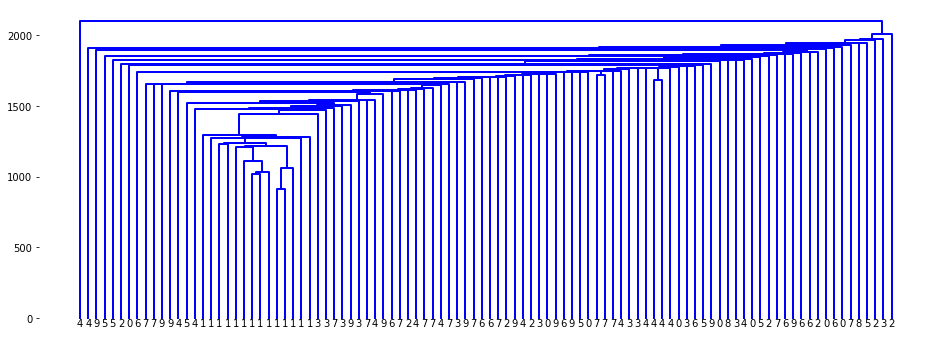

In [14]:
clusters = agghier(test_set[0:100], linktype='single')
dendrogram(clusters,test_labels[0:100])

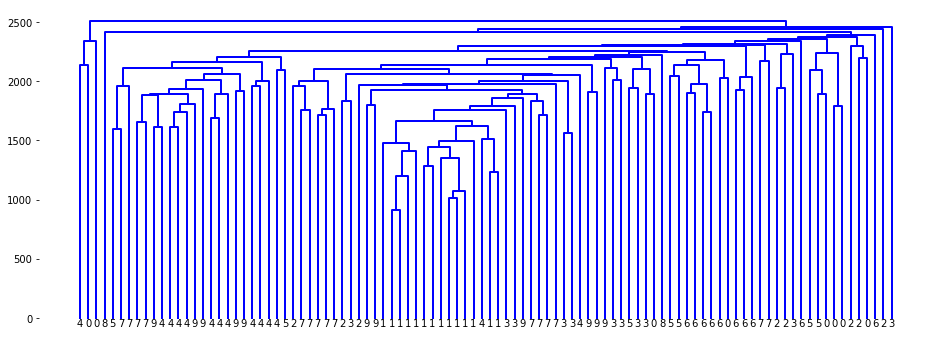

In [15]:
clusters = agghier(test_set[0:100], linktype='average')
dendrogram(clusters,test_labels[0:100])

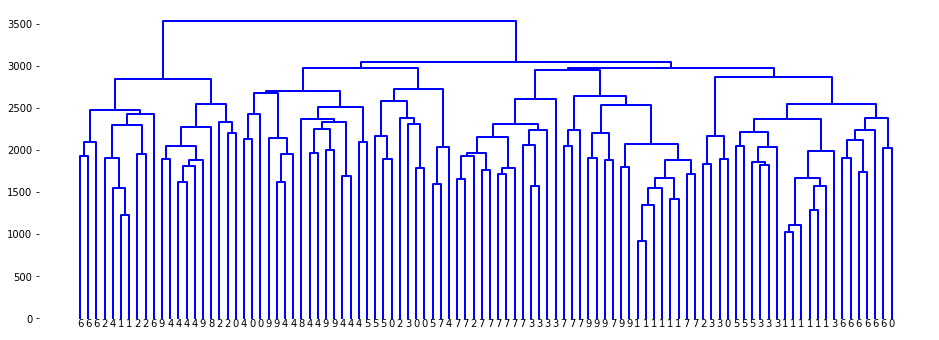

In [16]:
clusters = agghier(test_set[0:100], linktype='complete')
dendrogram(clusters,test_labels[0:100])